In [50]:
%matplotlib inline

In [51]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from pandas import DataFrame
import torch
import torch.nn as nn
import numpy as np

In [52]:
def plot_decision_boundary(X, y, net):
    # Plot the decision boundary
    # Determine grid range in x and y directions
    x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1

    # Set grid spacing parameter
    spacing = min(x_max - x_min, y_max - y_min) / 100

    # Create grid
    XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
                np.arange(y_min, y_max, spacing))

    # Concatenate data to match input
    data = np.hstack((XX.ravel().reshape(-1,1), 
                    YY.ravel().reshape(-1,1)))

    # Pass data to predict method 
    data_t = torch.FloatTensor(data)
    db_prob = net(data_t)

    # clf = np.where(db_prob<0.5,0,1)
    clf = db_prob.detach().numpy()

    Z = clf.reshape(XX.shape)

    # scatter plot, dots colored by class value
    df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    colors = {0:'green', 1:'orange'}
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    grouped = df.groupby('label')

    cm = plt.cm.get_cmap('viridis')

    plt.pcolormesh(XX, YY, Z, cmap='Blues')

    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    plt.show()

## 1. Generate the datasets


In [53]:
np.random.seed(0)
torch.manual_seed(0)
# generate 2d classification dataset. For the detail, please see https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles
X, y = make_circles(n_samples=500, noise=0.04, factor=0.4)

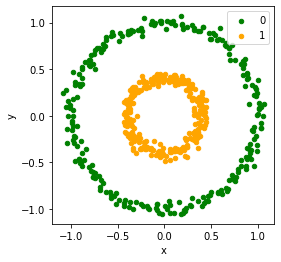

In [54]:
############################### Figure 1 ###############################

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'green', 1:'orange'}
fig, ax = plt.subplots()
ax.set_aspect('equal')
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

## 2. Define a Neural Network



In [55]:
net = nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Sigmoid()
)

## 3. Define a Loss function and optimizer


In [56]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

## 4. Train the network without mixup

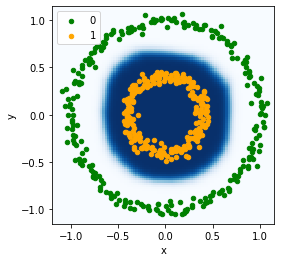

In [57]:
############################### Figure 2 ###############################
target = torch.FloatTensor(y).view(-1, 1)
for i in range(100):
    input = torch.FloatTensor(X)
    pred = net(input)

    optimizer.zero_grad()

    loss = criterion(pred, target)
    loss.backward()

    optimizer.step()

plot_decision_boundary(X, y, net)

## 5. Train the network with mixup

In [58]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    lam = np.random.beta(alpha, alpha)
    ##################################################
    #
    #   args:
    #
    #   x           : inputs
    #   y           : target labels of x
    #   alpha       : parameter of beta distribution
    #
    #   return:
    #      
    #   mixed_x     : the result of mix between x
    #   y_a, y_b    : target labels of mixed_x  ex) if x_1 (class 0) and x_2 (class 1) with lam (mixed_x = lam * x_1 + (1-lam) * x_2), then y_a, y_b are 0, 1 respectively. 
    #   lam
    #
    ##################################################    
    #
    #   your code
    #   # Obtain randomly permutated index to mixup different input x in batch
    #   # You can use the function torch.ranperm()
    #   # https://pytorch.org/docs/stable/torch.html?highlight=randperm#torch.randperm
    #   index = ... 
    #
    #   mixed_x = ...
    #   y_a = ...
    #   y_b = ...
    #
    
    index = torch.randperm(x.size(0))
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a ,y_b = y, y[index]

    ##################################################

    return mixed_x, y_a, y_b, lam

In [59]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    ##################################################
    #
    #   args:
    #
    #   criterion   : ex) nn.CrossEntropyLoss()
    #   pred        : outputs (= net(inputs))
    #   y_a, y_b    : target labels of mixed inputs
    #   lam         : lambda value of mixup
    #
    #   return:
    #      
    #   mixup_criterion
    #
    ##################################################    
    #
    #   your code
    #
    #   mixup_criterion = ...
    #
    mixup_criterion = lam * criterion(pred, y_a) + (1 - lam) * criterion(pred - y_b)
    ##################################################
    return mixup_criterion

In [60]:
############################## Figure 3 ###############################

net = nn.Sequential(
    nn.Linear(2, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

input = torch.FloatTensor(X)
target = torch.FloatTensor(y).view(-1, 1)

for i in range(100):
    
    x_mix, targets_a, targets_b, lam = mixup_data(input, target)

    pred = net(x_mix)

    optimizer.zero_grad()

    loss = mixup_criterion(criterion, pred, targets_a, targets_b, lam)
    loss.backward()

    optimizer.step()

plot_decision_boundary(X, y, net)

TypeError: ignored